#Lake Windermere eNDA metabarcoding data processing

In this exercise we will use [metaBEAT](https://github.com/HullUni-bioinformatics/metaBEAT), a tool tailored towards reproducible and efficient analyses of metabarcoding data that we have developed in-house. It is still under active development and will likely be extended further in the future. The pipeline is available in a Docker [container](https://registry.hub.docker.com/u/chrishah/metabeat/) with all necessary dependencies. The Docker image is building on [ReproPhylo](https://registry.hub.docker.com/u/szitenberg/reprophylo/).

The data we will be analyzing are CytB sequences amplified from eDNA samples collected from Lake Windermere. The experiment was designed to assess the potential of the eDNA approach to assess fish community compositions and was published recently (Haenfling et al. 2016). 
The metaBEAT tool is designed as a wrapper around a complete analysis from raw data, performing (optionally) de-multiplexing, quality filtering, clustering along the way, to OTU tables in biom format. It currently supports BLAST and phylogenetic placement (pplacer). The plan is to include further approaches in the future and to allow for efficient and standardized comparative assessments of all approaches. 

metBEAT offers a large number of options. Some of them will sound familiar and should make sense to you given your experience from the course so far. 


In [1]:
!metaBEAT_global.py -h

usage: metaBEAT.py [-h] [-Q <FILE>] [-B <FILE>] [--g_queries <FILE>] [-v] [-s]
                   [-f] [-p] [-t] [-b] [-m <string>] [-n <INT>] [-E] [-e]
                   [--read_stats_off] [--PCR_primer <FILE>]
                   [--trim_adapter <FILE>] [--trim_qual <INT>] [--phred <INT>]
                   [--trim_window <INT>] [--read_crop <INT>]
                   [--trim_minlength <INT>] [--merge] [--product_length <INT>]
                   [--merged_only] [--forward_only] [--length_filter <INT>]
                   [--length_deviation <FLOAT>] [-R <FILE>] [--gb_out <FILE>]
                   [--rec_check] [--gi_to_taxid <FILE>] [--cluster]
                   [--clust_match <FLOAT>] [--clust_cov <INT>]
                   [--blast_db <PATH>] [--blast_xml <PATH>]
                   [--min_ident <FLOAT>] [--min_ali_length <FLOAT>]
                   [--min_bit <INT>] [--refpkg <DIR>] [-o OUTPUT_PREFIX]
                   [--metadata METADATA] [--mock_meta_data]
                   [-@

We will limit ourselves to a basic processing (read trimming, -merging-, clustering) for now.

Minimum input for an anlysis is a set of query sequences in one or several files (accepted are a number of file formats, e.g. `fasta`, `fastq`). These will be run through the pipeline sequentially.

You will need to provide information on the nature and location of the query sequence files in a separate tab-delimited text files via the `-Q` flags,

Each line in this text file should look as follows:

`unique sample_ID <tab> format <tab> file1 <tab> file2`

An example can be found [here](https://github.com/HullUni-bioinformatics/metabarcode-course-2016/blob/master/data/exercise-3/example_data/QUERYfile).

You may generate the required text files in any text editor.

__Give it a go!__ 

Let's try it and open _`nano`_ in a terminal. 

You could call your samples anything, but we suggest that you use sample names that match the filenames of the Illumina data that you have downloaded before. See also the sample metadata that we've provided [here](https://github.com/HullUni-bioinformatics/metabarcode-course-2016/blob/master/data/raw_Illumina_data/sample_metadata/Sample_metadata.csv). 

The file should cover the samples `Windermere_01` - `Windermere_50`.

Example line:
```bash
Windermere_01	fastq	./reads/Windermere_01-CytB_1.fastq.gz	./reads/Windermere_01-CytB_2.fastq.gz
...
...
```

For the sake of reproducibility and because it's (arguably) much easier, you can also write a simple program that will generate the required file. 

In the cell below we produce it using a simple python script.

The script will list all files in the location to which you've downloaded your Illumina data (specified via the `'datadir'` variable. It assumes that there is a file ending in `_1.fastq` for each sample. For each such file, it will extract the sample name from the filename and format the required line for the text file accordingly. We call the resulting file `Querymap.txt` (specified in the `'to'` variable).

In [2]:
import os

datadir = '../raw_Illumina_data/reads/'
to = 'Querymap.txt'

####################
out_list = []
string = ''
files = os.listdir(datadir)
for f in sorted(files):
    if '_1.fastq' in f:
        string += "%s\tfastq\t%s%s\t%s/%s" %(f.replace('-CytB_1.fastq.gz', ''), datadir, f, datadir, f.replace('_1.fastq', '_2.fastq'))+'\n'

out = open(to, 'w')
out.write(string)
out.close()

Have a look (note that the output is probably line-wrapped). 

In [3]:
!head -n 4 Querymap.txt

Windermere_01	fastq	../raw_Illumina_data/reads/Windermere_01-CytB_1.fastq.gz	../raw_Illumina_data/reads//Windermere_01-CytB_2.fastq.gz
Windermere_02	fastq	../raw_Illumina_data/reads/Windermere_02-CytB_1.fastq.gz	../raw_Illumina_data/reads//Windermere_02-CytB_2.fastq.gz
Windermere_03	fastq	../raw_Illumina_data/reads/Windermere_03-CytB_1.fastq.gz	../raw_Illumina_data/reads//Windermere_03-CytB_2.fastq.gz
Windermere_04	fastq	../raw_Illumina_data/reads/Windermere_04-CytB_1.fastq.gz	../raw_Illumina_data/reads//Windermere_04-CytB_2.fastq.gz



Now, we will be perform basic quality trimming and clipping (`Trimmomatic`), paired-end read merging (`flash`) and read clustering at 100 % identity (`vsearch`), essentially as you did in the previous [exercise](https://github.com/HullUni-bioinformatics/metabarcode-course-2016/blob/master/data/exercise-2/fastq_explore_and_process.ipynb). Only this time we will be using our custom pipeline `metaBEAT` to process all 68 samples in one go.

See the below command:

In [4]:
%%bash

echo -e "Starttime: $(date)\n"

metaBEAT_global.py \
-Q Querymap.txt \
--trim_qual 30 --trim_minlength 100 \
--merge --product_length 400 --forward_only \
--cluster --clust_match 1 --clust_cov 3 \
-m CytB -o CytB-trim30min100-merge-c3-id1 \
-n 5 -v &> log

echo -e "Endtime: $(date)\n"

Starttime: Sat Sep 10 14:10:12 UTC 2016

Endtime: Sat Sep 10 14:27:25 UTC 2016



Read processing will take about 20-30 minutes.

Some more details about the above command:

```bash
metaBEAT_global.py \ #call the program
-Q Querymap.txt \ #path to the Querymap
--trim_qual 30 \ #minimum quality for trimming is prhed Q30 (trimmomatic)
--trim_minlength 100 \ #only retain reads longer than 100 bp after trimming
--merge \ #merge overlapping read pairs (flash)
--forward_only \ #retain only forward read in cases where read pairs don't merge
--product_length 400 \ #expected length of merged read is roughly 400 bp
--cluster \ #cluster sequences (vsearch)
--clust_match 1 \ #cluster at 100 % identity
--clust_cov 3 \ #minimum coverage of 3 reads to retain cluster
-m CytB \ #arbitrary name of the marker
-o CytB-trim30min100-merge-c3-id1 \ #prefix for results files
-n 5 \ #use 5 threads
-v &> log #write verbose output to file called log
```

While the read processing is running we can continue with the course program. Next we will focus on constructing/curating a custom reference database.



metaBEAT will generate a directory with all temporary files that were create during the processing for each sample and will record useful stats summarizing the data processing in the file `CytB-trim30min100-merge-c3-id1_read_stats.csv`. Should look roughly like [this](https://github.com/HullUni-bioinformatics/metabarcode-course-2016/blob/master/data/exercise-3/results_backup/CytB-trim30min100-merge-c3-id1_read_stats.csv).
 
You can explore the table manually or we can quickly plot out some of these stats here in the notebook, e.g. like so:

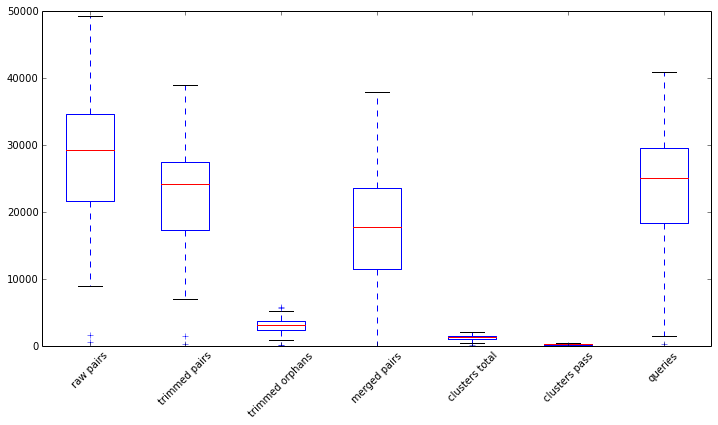

In [13]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# parse metaBEAT_read_stats.csv
stats_file = 'CytB-trim30min100-merge-c3-id1_read_stats.csv'

################
## prepare data
total_pairs = []
trimmed_pairs = []
trimmed_orphams = []
merged_pairs = []
clusters_total = []
clusters_ok = []
queries = []

for l in open(stats_file, 'r').readlines()[1:]:
    smpl, tot, trimtot, trimpe, trimorph, merged, n1,n2,n3,n4, q = l.rstrip().split(',')
    total_pairs.append(int(tot)/2.0)
    trimmed_pairs.append(int(trimpe)/2.0)
    trimmed_orphams.append(int(trimorph))
    merged_pairs.append(int(merged))
    clusters_total.append(int(n2))
    clusters_ok.append(int(n4))
    queries.append(int(q))
    
    
dat = [total_pairs, trimmed_pairs, trimmed_orphams, merged_pairs, clusters_total, clusters_ok, queries]
dat = [np.array(d) for d in dat]
x = ['raw pairs', 'trimmed pairs', 'trimmed orphans', 'merged pairs', 'clusters total', 'clusters pass', 'queries']

################
## do the plotting
fig = plt.figure(1, figsize=(12, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(dat)
bp = ax.set_xticklabels(x, rotation=45)



Plot only Number of clusters.

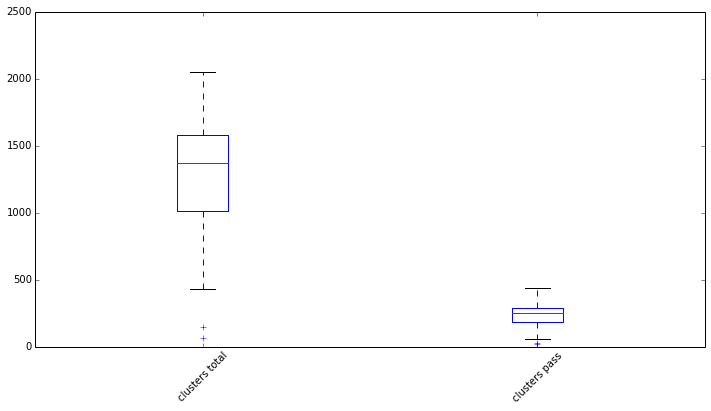

In [14]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


####
dat = [clusters_total, clusters_ok]
dat = [np.array(d) for d in dat]
x = ['clusters total', 'clusters pass']

fig = plt.figure(1, figsize=(12, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(dat)
bp = ax.set_xticklabels(x, rotation=45)


The final step in the processing will be global clustering of the centroids from all clusters from all samples to produce denovo `OTUs`. The temporary files from the global clustering and the final OTU table were written to the directory `GLOBAL`.



In [16]:
!ls GLOBAL/

CytB-trim30min100-merge-c3-id1-OTU-denovo.biom	global_queries.fasta
CytB-trim30min100-merge-c3-id1-OTU-denovo.tsv	global.uc
global_centroids.fasta


You can briefly explore the denovo OTU table (numbers are reads) to see how OTUs are distributed across your samples. See also an example [here](https://github.com/HullUni-bioinformatics/metabarcode-course-2016/blob/master/data/exercise-3/results_backup/CytB-trim30min100-merge-c3-id1-OTU-denovo.tsv).

You can find detailed info on what metaBEAT did to each sample in the log file `log`. It contains the exact commands that were run for each sample during each step of the process.

It's a large text file - just have a look at the first 100 lines for a start. 

In [17]:
!head -n 100 log


metaBEAT - metaBarcoding and Environmental DNA Analyses tool
version: v.0.94-global


Sat Sep 10 14:10:12 2016

/usr/bin/metaBEAT_global.py -Q Querymap.txt --trim_qual 30 --trim_minlength 100 --merge --product_length 400 --forward_only --cluster --clust_match 1 --clust_cov 3 -m CytB -o CytB-trim30min100-merge-c3-id1 -n 5 -v


metaBEAT may be querying NCBI's Entrez databases to fetch/verify taxonomic ids. Entrez User requirements state that you need to identify yourself by providing an email address so that NCBI can contact you in case there is a problem.

As the mail address is not specified in the script itself (variable 'Entrez.email'), metaBEAT expects a simple text file called 'user_email.txt' that contains your email address (first line of file) in the same location as the metaBEAT.py script (in your case: /usr/bin/)

found 'c.hahn@hull.ac.uk' in /usr/bin/user_email.txt


Parsing querylist file

Number of samples to process: 57
Sequence input format: defaultdict(<type 'int'>, {'f

```bash
...
...
...
```

__WELL DONE!__